In [3]:
%load_ext autoreload
%autoreload 2
import jax.numpy as jnp
import numpy as np
from models.variable_susceptibility import (
    simulate_variable_susceptibility_hom,
    simulate_variable_susceptibility_pol,
    N_COMPARTMENTS
)
from core.interaction import create_contact_matrix
from typing import Dict, Tuple, Optional, Any
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from typing import Tuple, Dict, Any
from core.sir_base import StateType, ParamType
from core.interaction import create_contact_matrix


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
def initialize_states(
    beta_params: Tuple[float, float],
    initial_infected_prop: float = 1e-4
) -> StateType:
    """Initialize states for fixed-size system normalized to total population 1
    
    Args:
        beta_params: Parameters (a, b) for beta distribution of populations
        initial_infected_prop: Initial proportion infected in each group
        
    Returns:
        Tuple of (S, I, R) arrays
    """
    from core.population import my_beta_asymmetric
    
    # Generate normalized population distribution
    populations = my_beta_asymmetric(beta_params[0], beta_params[1], N_COMPARTMENTS, norm=1.0)
    
    # Initialize compartments
    S = populations * (1 - initial_infected_prop)
    I = populations * initial_infected_prop
    R = jnp.zeros_like(populations)
    
    return S, I, R

[0.20759128 0.02066021 0.01472021 0.01209136 0.01053072 0.00947127
 0.00869383 0.0080935  0.00761292 0.00721779 0.00688613 0.00660316
 0.00635851 0.00614466 0.00595603 0.00578836 0.00563833 0.00550333
 0.00538127 0.00527045 0.00516947 0.00507718 0.0049926  0.00491493
 0.00484345 0.00477759 0.00471682 0.00466071 0.00460887 0.00456096
 0.0045167  0.00447583 0.00443811 0.00440335 0.00437136 0.00434201
 0.00431513 0.00429062 0.00426836 0.00424825 0.00423022 0.00421419
 0.00420009 0.00418787 0.00417747 0.00416887 0.00416203 0.00415692
 0.00415352 0.00415183 0.00415183 0.00415352 0.00415692 0.00416203
 0.00416887 0.00417747 0.00418787 0.00420009 0.00421419 0.00423022
 0.00424825 0.00426836 0.00429062 0.00431513 0.00434201 0.00437136
 0.00440335 0.00443811 0.00447583 0.0045167  0.00456096 0.00460887
 0.00466071 0.00471682 0.00477759 0.00484345 0.00491493 0.0049926
 0.00507718 0.00516947 0.00527045 0.00538127 0.00550333 0.00563833
 0.00578836 0.00595603 0.00614466 0.00635851 0.00660316 0.00688

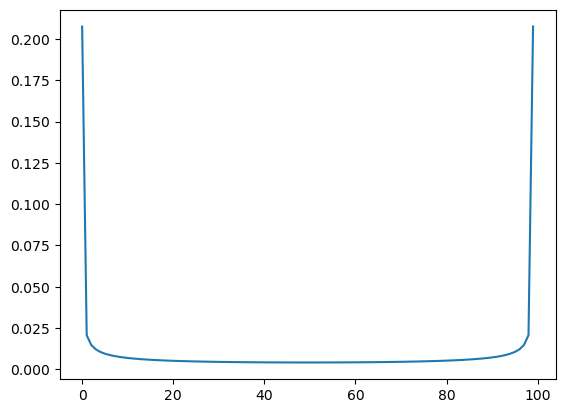

In [ ]:

POP = np.array(pops)
print(POP)

plt.plot(POP)

In [34]:
def my_cm_fast(n_groups: int, homophilic_tendency: float, populations: jnp.ndarray) -> jnp.ndarray:
    
    # Generate raw contact rates based on group differences
    positions = jnp.linspace(0, 1, n_groups)
    diffs = jnp.abs(positions[:, None] - positions[None, :])
    C = jnp.exp(-homophilic_tendency * diffs)
    
    # Normalize by total weighted contacts
    norm = jnp.sum(C * populations[:, None] * populations[None, :])
    C = C / norm
    
    # Weight by target population sizes to get ICM
    #ICM = C * populations[None, :]
    
    return C

In [35]:
def my_cm_slow(Nbins, h, POP):
    opn = np.linspace(0,1,Nbins)
    CM = np.zeros((Nbins,Nbins))
    for i in range(Nbins):
        for j in range(Nbins):
            CM[i,j] = np.exp(-h*np.abs(opn[i]-opn[j]))
    norm = 0
    for i in range(Nbins):
        for j in range(Nbins):
            norm += CM[i,j]*POP[i]*POP[j]
    CM = CM/norm

    return CM   

0.5485953379204037 1.491236738246383
0.54859537 1.4912368


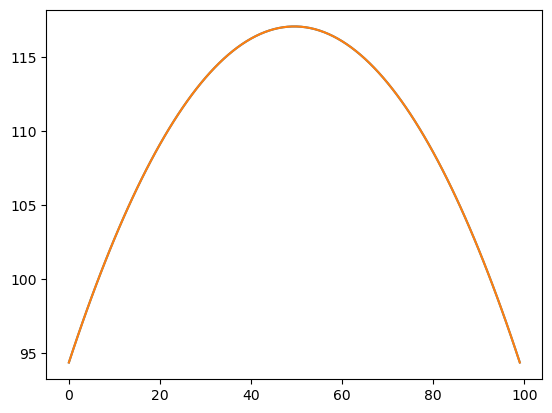

In [36]:
slow_ICM = np.array(my_cm_slow(100, 1.0, POP))
fast_ICM = np.array(my_cm_fast(100, 1.0, POP))

print(np.min(slow_ICM), np.max(slow_ICM))
print(np.min(fast_ICM), np.max(fast_ICM))

slow_x = np.sum(slow_ICM, axis=0)
fast_x = np.sum(fast_ICM, axis=0)

plt.plot(slow_x)
plt.plot(fast_x)

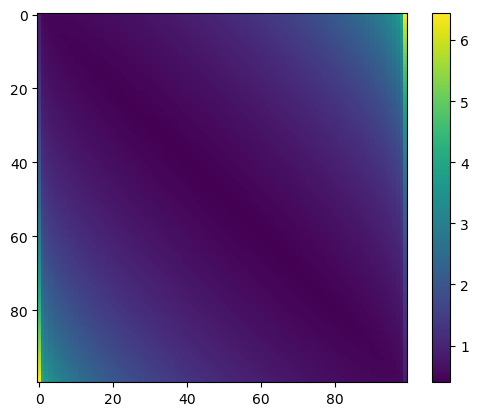

In [ ]:
h = -2
initial_state = initialize_states([0.9,0.9], 0.000000001)
pops = initial_state[0] + initial_state[1] + initial_state[2]
C = my_cm(100, h, pops)
C = np.array(C)
plt.imshow(C)
plt.colorbar()